# Decision Tree Model with One Hot Encoder for Categorical Variables

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pandas
import numpy
import itertools
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.metrics import log_loss
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB

In [3]:
import loan_approval_lib
from loan_approval_lib import logspace, linspace

In [4]:
data = loan_approval_lib.load_original_data()

In [5]:
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0


In [6]:
data_train = loan_approval_lib.load_data_train()

In [7]:
data_test = loan_approval_lib.load_data_test()

# Data Cleaning

In [8]:
columns = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_default_on_file'
]

for column in columns:
    row_count_1 = len(data)

    if column == 'person_age':
        data = data[data['person_age'] <= 100]

    if column == 'person_emp_length':
        data = data[data['person_emp_length'] <= 100]

    data = data[data[column].isna() == False]
    
    row_count_2 = len(data)
    row_count_diff = row_count_1 - row_count_2
    print(f'column {column}, number of removed rows: {row_count_diff}')
    

column person_age, number of removed rows: 5
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 897
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 3047
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


# Loan Grade

In [9]:
loan_grades = list(sorted(data['loan_grade'].unique()))

for loan_grade in loan_grades:
    data.loc[data['loan_grade'] == loan_grade, 'loan_grade_numerical'] = ord(loan_grade) - ord('A')

    data_train.loc[data_train['loan_grade'] == loan_grade, 'loan_grade_numerical'] = ord(loan_grade) - ord('A')
    
    data_test.loc[data_test['loan_grade'] == loan_grade, 'loan_grade_numerical'] = ord(loan_grade) - ord('A')

In [10]:
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,loan_grade_numerical
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0,1.0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1,2.0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1,2.0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1,2.0
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,N,2,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0,2.0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0,0.0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1,1.0
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0,1.0


# Person Home Ownership

In [11]:
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(data[['person_home_ownership']])
transformed = encoder.transform(data[['person_home_ownership']])

data = pandas.concat(
    [
        data,
        pandas.DataFrame(
            transformed,
            index=data.index,
            #columns = [f'person_home_ownership_{category}' for category in encoder.categories_],
            columns=encoder.get_feature_names_out(['person_home_ownership']),
        ),
    ],
    axis=1,
)

data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,loan_grade_numerical,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0,1.0,0.0,0.0,1.0,0.0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1,2.0,1.0,0.0,0.0,0.0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1,2.0,0.0,0.0,0.0,1.0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1,2.0,0.0,0.0,0.0,1.0
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,N,2,1,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0,2.0,1.0,0.0,0.0,0.0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0,0.0,1.0,0.0,0.0,0.0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1,1.0,0.0,0.0,0.0,1.0
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0,1.0,1.0,0.0,0.0,0.0


In [12]:
encoder.categories_

[array(['MORTGAGE', 'OTHER', 'OWN', 'RENT'], dtype=object)]

In [13]:
encoder.get_feature_names_out(['person_home_ownership'])

array(['person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT'],
      dtype=object)

In [14]:
encoder.transform(
    [['MORTGAGE'], ['OTHER'], ['OWN'], ['RENT']]
)

/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [15]:
transformed = encoder.transform(data_train[['person_home_ownership']])

data_train = pandas.concat(
    [
        data_train,
        pandas.DataFrame(
            transformed,
            index=data_train.index,
            #columns = [f'person_home_ownership_{category}' for category in encoder.categories_],
            columns=encoder.get_feature_names_out(['person_home_ownership']),
        ),
    ],
    axis=1,
)

In [16]:
transformed = encoder.transform(data_test[['person_home_ownership']])

data_test = pandas.concat(
    [
        data_test,
        pandas.DataFrame(
            transformed,
            index=data_test.index,
            #columns = [f'person_home_ownership_{category}' for category in encoder.categories_],
            columns=encoder.get_feature_names_out(['person_home_ownership']),
        ),
    ],
    axis=1,
)

# Loan Intent

In [17]:
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(data[['loan_intent']])
transformed = encoder.transform(data[['loan_intent']])

data = pandas.concat(
    [
        data,
        pandas.DataFrame(
            transformed,
            index=data.index,
            #columns = [f'person_home_ownership_{category}' for category in encoder.categories_],
            columns=encoder.get_feature_names_out(['loan_intent']),
        ),
    ],
    axis=1,
)

data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,...,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,N,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
transformed = encoder.transform(data_train[['loan_intent']])

data_train = pandas.concat(
    [
        data_train,
        pandas.DataFrame(
            transformed,
            index=data_train.index,
            #columns = [f'person_home_ownership_{category}' for category in encoder.categories_],
            columns=encoder.get_feature_names_out(['loan_intent']),
        ),
    ],
    axis=1,
)

In [19]:
transformed = encoder.transform(data_test[['loan_intent']])

data_test = pandas.concat(
    [
        data_test,
        pandas.DataFrame(
            transformed,
            index=data_test.index,
            #columns = [f'person_home_ownership_{category}' for category in encoder.categories_],
            columns=encoder.get_feature_names_out(['loan_intent']),
        ),
    ],
    axis=1,
)

# Default on File

In [20]:
data.loc[data['cb_person_default_on_file'] == 'Y', 'cb_person_default_on_file_vote'] = 1
data.loc[data['cb_person_default_on_file'] == 'N', 'cb_person_default_on_file_vote'] = -1

data['cb_person_default_on_file_predict'] = data['cb_person_default_on_file_vote'].map(lambda x: 0 if x == -1 else 1)

In [21]:
(data['loan_status'] == data['cb_person_default_on_file_predict']).sum() / len(data)

np.float64(0.739731768650461)

In [22]:
data_train.loc[data_train['cb_person_default_on_file'] == 'Y', 'cb_person_default_on_file_vote'] = 1
data_train.loc[data_train['cb_person_default_on_file'] == 'N', 'cb_person_default_on_file_vote'] = -1

In [23]:
data_test.loc[data_test['cb_person_default_on_file'] == 'Y', 'cb_person_default_on_file_vote'] = 1
data_test.loc[data_test['cb_person_default_on_file'] == 'N', 'cb_person_default_on_file_vote'] = -1

# Choose Columns for Tree Model

In [24]:
for column in data.columns:
    print(column)

person_age
person_income
person_home_ownership
person_emp_length
loan_intent
loan_grade
loan_amnt
loan_int_rate
loan_percent_income
cb_person_default_on_file
cb_person_cred_hist_length
loan_status
loan_grade_numerical
person_home_ownership_MORTGAGE
person_home_ownership_OTHER
person_home_ownership_OWN
person_home_ownership_RENT
loan_intent_DEBTCONSOLIDATION
loan_intent_EDUCATION
loan_intent_HOMEIMPROVEMENT
loan_intent_MEDICAL
loan_intent_PERSONAL
loan_intent_VENTURE
cb_person_default_on_file_vote
cb_person_default_on_file_predict


In [25]:
decision_tree_columns = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length',
    'loan_grade_numerical',
    'person_home_ownership_MORTGAGE',
    'person_home_ownership_OTHER',
    'person_home_ownership_OWN',
    'person_home_ownership_RENT',
    'loan_intent_DEBTCONSOLIDATION',
    'loan_intent_EDUCATION',
    'loan_intent_HOMEIMPROVEMENT',
    'loan_intent_MEDICAL',
    'loan_intent_PERSONAL',
    'loan_intent_VENTURE',
    'cb_person_default_on_file',
]

In [26]:
for column in data.columns:
    if not column in decision_tree_columns:
        print(f'column {column} is excluded from the model')

column person_home_ownership is excluded from the model
column loan_intent is excluded from the model
column loan_grade is excluded from the model
column loan_status is excluded from the model
column cb_person_default_on_file_vote is excluded from the model
column cb_person_default_on_file_predict is excluded from the model


In [27]:
decision_tree_columns_with_id = [
    column for column in decision_tree_columns
]
decision_tree_columns_with_id.append('id')

# Copy DataFrame and drop unused columns

In [28]:
data_copy = data.copy()

data_copy.drop(
    columns=[
        'person_home_ownership',
        'loan_intent',
        'loan_grade',
        'cb_person_default_on_file_vote',
        'cb_person_default_on_file_predict',
    ],
    inplace=True,
)

data_copy['cb_person_default_on_file'] = data_copy['cb_person_default_on_file'].map(lambda x: 1 if x == 'Y' else 0)

In [29]:
data_copy

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,loan_grade_numerical,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
1,21,9600,5.0,1000,11.14,0.10,0,2,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,25,9600,1.0,5500,12.87,0.57,0,3,1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,23,65500,4.0,35000,15.23,0.53,0,2,1,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,24,54400,8.0,35000,14.27,0.55,1,4,1,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,21,9900,2.0,2500,7.14,0.25,0,2,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0.11,0,30,0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32577,54,120000,4.0,17625,7.49,0.15,0,19,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32578,65,76000,3.0,35000,10.99,0.46,0,28,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
32579,56,150000,5.0,15000,11.48,0.10,0,26,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
for column in data_copy.columns:
    print(column)

person_age
person_income
person_emp_length
loan_amnt
loan_int_rate
loan_percent_income
cb_person_default_on_file
cb_person_cred_hist_length
loan_status
loan_grade_numerical
person_home_ownership_MORTGAGE
person_home_ownership_OTHER
person_home_ownership_OWN
person_home_ownership_RENT
loan_intent_DEBTCONSOLIDATION
loan_intent_EDUCATION
loan_intent_HOMEIMPROVEMENT
loan_intent_MEDICAL
loan_intent_PERSONAL
loan_intent_VENTURE


In [31]:
data_train_copy = data_train.copy()

data_train_copy.drop(
    columns=[
        'person_home_ownership',
        'loan_intent',
        'loan_grade',
    ],
    inplace=True,
)

data_train_copy['cb_person_default_on_file'] = data_train_copy['cb_person_default_on_file'].map(lambda x: 1 if x == 'Y' else 0)

In [32]:
data_test_copy = data_test.copy()

data_test_copy.drop(
    columns=[
        'person_home_ownership',
        'loan_intent',
        'loan_grade',
    ],
    inplace=True,
)

data_test_copy['cb_person_default_on_file'] = data_test_copy['cb_person_default_on_file'].map(lambda x: 1 if x == 'Y' else 0)

# Split data into test and training datasets

In [33]:
len(data_copy)

28632

In [34]:
data_copy_train = data_copy.iloc[0:18000].copy()

In [35]:
data_copy_test = data_copy.iloc[18000:].copy()

In [36]:
len(data_copy_train)

18000

In [37]:
len(data_copy_test)

10632

In [38]:
X = data_copy_train[decision_tree_columns].copy()
Y = data_copy_train['loan_status'].copy()

In [39]:
X_test = data_copy_test[decision_tree_columns].copy()

# Decision Tree Model - Max Depth 1

In [40]:
max_depth = 1

In [41]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
clf = clf.fit(X, Y)

In [42]:
Z = clf.predict(X)
data_copy_train['loan_status_tree_predict'] = Z
(data_copy_train['loan_status'] == data_copy_train['loan_status_tree_predict']).sum() / len(data_copy_train)

np.float64(0.8240555555555555)

In [43]:
feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances[feature_importances > 0.0])

loan_percent_income    1.0
dtype: float64


In [44]:
Z_test = clf.predict(X_test)
data_copy_test['loan_status_tree_predict'] = Z_test
(data_copy_test['loan_status'] == data_copy_test['loan_status_tree_predict']).sum() / len(data_copy_test)

np.float64(0.844714070729872)

# Decision Tree Model - Max Depth 2

In [45]:
max_depth = 2

In [46]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
clf = clf.fit(X, Y)

In [47]:
Z = clf.predict(X)
data_copy_train['loan_status_tree_predict'] = Z
(data_copy_train['loan_status'] == data_copy_train['loan_status_tree_predict']).sum() / len(data_copy_train)

np.float64(0.8712777777777778)

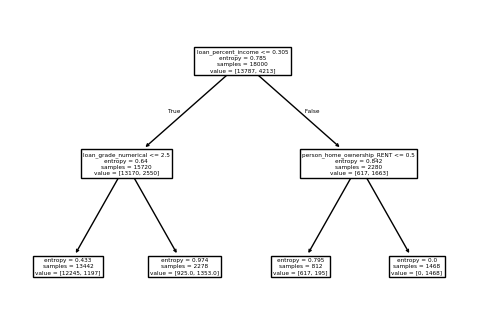

In [48]:
width = 6
height = 4
plt.figure(figsize=(width, height))

#tree_plot_max_depth = 6
tree.plot_tree(clf, feature_names=X.columns) #, max_depth=tree_plot_max_depth)

plt.savefig('tree-max-depth-numerical-onehot-2-1.pdf')
plt.savefig('tree-max-depth-numerical-onehot-2-1.png')
plt.show()

In [49]:
feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances[feature_importances > 0.0])

loan_percent_income           0.396194
loan_grade_numerical          0.369497
person_home_ownership_RENT    0.234308
dtype: float64


In [50]:
Z_test = clf.predict(X_test)
data_copy_test['loan_status_tree_predict'] = Z_test
(data_copy_test['loan_status'] == data_copy_test['loan_status_tree_predict']).sum() / len(data_copy_test)

np.float64(0.875)

# Decision Tree Model - Max Depth 3

In [51]:
max_depth = 3

In [52]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
clf = clf.fit(X, Y)

In [53]:
Z = clf.predict(X)
data_copy_train['loan_status_tree_predict'] = Z
(data_copy_train['loan_status'] == data_copy_train['loan_status_tree_predict']).sum() / len(data_copy_train)

np.float64(0.881)

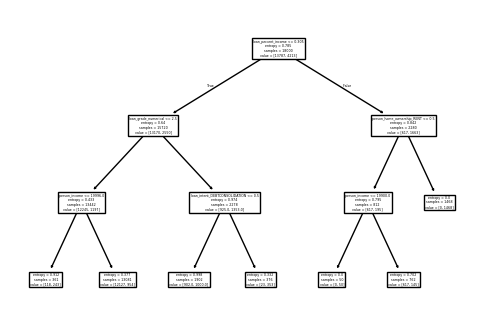

In [54]:
width = 6
height = 4
plt.figure(figsize=(width, height))

#tree_plot_max_depth = 6
tree.plot_tree(clf, feature_names=X.columns) #, max_depth=tree_plot_max_depth)

plt.savefig('tree-max-depth-numerical-onehot-3-1.pdf')
plt.savefig('tree-max-depth-numerical-onehot-3-1.png')
plt.show()

In [55]:
feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances[feature_importances > 0.0])

loan_percent_income              0.341362
loan_grade_numerical             0.318360
person_home_ownership_RENT       0.201881
person_income                    0.107289
loan_intent_DEBTCONSOLIDATION    0.031108
dtype: float64


In [56]:
Z_test = clf.predict(X_test)
data_copy_test['loan_status_tree_predict'] = Z_test
(data_copy_test['loan_status'] == data_copy_test['loan_status_tree_predict']).sum() / len(data_copy_test)

np.float64(0.8792325056433409)

In [57]:
# x[5] and x[11] seem important
# explained by loan_percent_income (x[5] > 0.305 and person_home_ownership = RENT

# Decision Tree Model - Max Depth 4

In [61]:
def run_decision_tree_model_with_max_depth(data_copy_train, data_copy_test, decision_tree_columns, max_depth):

    X = data_copy_train[decision_tree_columns].copy()
    Y = data_copy_train['loan_status'].copy()

    X_test = data_copy_test[decision_tree_columns].copy()
    
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf = clf.fit(X, Y)

    Z = clf.predict(X)
    data_copy_train['loan_status_tree_predict'] = Z
    accuracy_in_sample = (data_copy_train['loan_status'] == data_copy_train['loan_status_tree_predict']).sum() / len(data_copy_train)

    feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    feature_importances = feature_importances[feature_importances > 0]

    Z_test = clf.predict(X_test)
    data_copy_test['loan_status_tree_predict'] = Z_test
    accuracy_out_of_sample = (data_copy_test['loan_status'] == data_copy_test['loan_status_tree_predict']).sum() / len(data_copy_test)

    return (accuracy_in_sample, accuracy_out_of_sample, feature_importances)

In [62]:
(
    accuracy_in_sample,
    accuracy_out_of_sample,
    feature_importances,
) = run_decision_tree_model_with_max_depth(
    data_copy_train.copy(),
    data_copy_test.copy(),
    decision_tree_columns,
    4,
)

print(f'accuracy in sample: {accuracy_in_sample}')
print(f'accuracy out of sample: {accuracy_out_of_sample}')
print(feature_importances)

accuracy in sample: 0.8999444444444444
accuracy out of sample: 0.9077313769751693
loan_percent_income              0.338336
loan_grade_numerical             0.292248
person_home_ownership_RENT       0.179540
person_income                    0.113461
loan_intent_MEDICAL              0.033467
loan_intent_DEBTCONSOLIDATION    0.027666
person_home_ownership_OWN        0.015284
dtype: float64


# Decision Tree Model - Max Depth 5

In [76]:
(
    accuracy_in_sample,
    accuracy_out_of_sample,
    feature_importances,
) = run_decision_tree_model_with_max_depth(
    data_copy_train.copy(),
    data_copy_test.copy(),
    decision_tree_columns,
    5,
)

print(f'accuracy in sample: {accuracy_in_sample}')
print(f'accuracy out of sample: {accuracy_out_of_sample}')
print(feature_importances)

accuracy in sample: 0.9181666666666667
accuracy out of sample: 0.9193002257336343
loan_percent_income               0.313706
loan_grade_numerical              0.273107
person_home_ownership_RENT        0.167636
person_income                     0.105201
person_emp_length                 0.039473
loan_intent_MEDICAL               0.031031
loan_intent_DEBTCONSOLIDATION     0.027868
person_home_ownership_OWN         0.016820
loan_intent_HOMEIMPROVEMENT       0.012631
loan_int_rate                     0.009880
person_home_ownership_MORTGAGE    0.002646
dtype: float64


## Make prediction for Kaggle Competition Test dataset

In [77]:
(
    accuracy_in_sample,
    accuracy_out_of_sample,
    feature_importances,
) = run_decision_tree_model_with_max_depth(
    data_copy_test.copy(),
    data_train_copy.copy(),
    decision_tree_columns,
    5,
)

print(f'accuracy in sample: {accuracy_in_sample}')
print(f'accuracy out of sample: {accuracy_out_of_sample}')
print(feature_importances)

accuracy in sample: 0.9296463506395787
accuracy out of sample: 0.9457242731690682
loan_grade_numerical             0.278594
loan_percent_income              0.266559
person_home_ownership_RENT       0.198907
person_income                    0.055210
person_emp_length                0.044552
loan_intent_MEDICAL              0.044412
loan_intent_DEBTCONSOLIDATION    0.039870
person_home_ownership_OWN        0.038718
loan_int_rate                    0.021657
loan_intent_VENTURE              0.011522
dtype: float64


In [65]:
data_copy_test

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,loan_grade_numerical,...,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_status_tree_predict
20476,28,33763,5.0,4800,7.14,0.14,0,5,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
20477,28,34000,1.0,4800,11.49,0.14,0,7,0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
20478,32,29000,17.0,4800,16.29,0.17,1,7,1,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
20479,33,40056,5.0,16750,9.88,0.42,0,6,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
20480,28,35000,2.0,4800,13.49,0.14,0,5,0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0.11,0,30,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
32577,54,120000,4.0,17625,7.49,0.15,0,19,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
32578,65,76000,3.0,35000,10.99,0.46,0,28,1,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1
32579,56,150000,5.0,15000,11.48,0.10,0,26,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


### Max depth 5

In [75]:
X = data_copy_train[decision_tree_columns].copy()
Y = data_copy_train['loan_status'].copy()

X_test = data_test_copy[decision_tree_columns_with_id].copy()

clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf = clf.fit(X, Y)

Z = clf.predict(X)
data_copy_train['loan_status_tree_predict'] = Z
accuracy_in_sample = (data_copy_train['loan_status'] == data_copy_train['loan_status_tree_predict']).sum() / len(data_copy_train)

feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances = feature_importances[feature_importances > 0]

Z_test = clf.predict(X_test[decision_tree_columns])
data_test_copy['loan_status'] = Z_test

print(f'accuracy in sample: {accuracy_in_sample}')
print(feature_importances)

data_test_copy[['id', 'loan_status']].to_csv(f'data_test_submission_decision_tree_max_depth_5.csv', index=False)

accuracy in sample: 0.9181666666666667
loan_percent_income               0.313706
loan_grade_numerical              0.273107
person_home_ownership_RENT        0.167636
person_income                     0.105201
person_emp_length                 0.039473
loan_intent_MEDICAL               0.031031
loan_intent_DEBTCONSOLIDATION     0.027868
person_home_ownership_OWN         0.016820
loan_intent_HOMEIMPROVEMENT       0.012631
loan_int_rate                     0.009880
person_home_ownership_MORTGAGE    0.002646
dtype: float64


### No max depth

In [74]:
X = data_copy_train[decision_tree_columns].copy()
Y = data_copy_train['loan_status'].copy()

X_test = data_test_copy[decision_tree_columns_with_id].copy()

clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=None)
clf = clf.fit(X, Y)

Z = clf.predict(X)
data_copy_train['loan_status_tree_predict'] = Z
accuracy_in_sample = (data_copy_train['loan_status'] == data_copy_train['loan_status_tree_predict']).sum() / len(data_copy_train)

feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances = feature_importances[feature_importances > 0]

Z_test = clf.predict(X_test[decision_tree_columns])
data_test_copy['loan_status'] = Z_test

print(f'accuracy in sample: {accuracy_in_sample}')
print(feature_importances)

data_test_copy[['id', 'loan_status']].to_csv(f'data_test_submission_decision_tree_max_depth_none.csv', index=False)

accuracy in sample: 1.0
loan_percent_income               0.207872
loan_grade_numerical              0.162984
person_income                     0.156445
person_home_ownership_RENT        0.125787
loan_int_rate                     0.073710
person_emp_length                 0.054749
person_age                        0.046897
loan_amnt                         0.046033
loan_intent_MEDICAL               0.021312
cb_person_cred_hist_length        0.021114
loan_intent_DEBTCONSOLIDATION     0.019907
person_home_ownership_OWN         0.018624
loan_intent_HOMEIMPROVEMENT       0.015265
loan_intent_VENTURE               0.009842
person_home_ownership_MORTGAGE    0.005567
loan_intent_PERSONAL              0.005087
loan_intent_EDUCATION             0.004872
cb_person_default_on_file         0.002772
person_home_ownership_OTHER       0.001164
dtype: float64


# Decision Tree Model - Max Depth 6

In [79]:
# Original dataset

(
    accuracy_in_sample,
    accuracy_out_of_sample,
    feature_importances,
) = run_decision_tree_model_with_max_depth(
    data_copy_train.copy(),
    data_copy_test.copy(),
    decision_tree_columns,
    6,
)

print(f'accuracy in sample: {accuracy_in_sample}')
print(f'accuracy out of sample: {accuracy_out_of_sample}')
print(feature_importances)

accuracy in sample: 0.9272777777777778
accuracy out of sample: 0.9294582392776524
loan_percent_income               0.289242
loan_grade_numerical              0.251810
person_home_ownership_RENT        0.206551
person_income                     0.102668
person_emp_length                 0.036395
person_home_ownership_OWN         0.029262
loan_intent_MEDICAL               0.028611
loan_intent_DEBTCONSOLIDATION     0.025695
loan_intent_HOMEIMPROVEMENT       0.012539
loan_int_rate                     0.009110
loan_intent_VENTURE               0.004524
person_home_ownership_MORTGAGE    0.002440
cb_person_cred_hist_length        0.001154
dtype: float64


In [80]:
# Original dataset for training, Kaggle competition dataset for testing

(
    accuracy_in_sample,
    accuracy_out_of_sample,
    feature_importances,
) = run_decision_tree_model_with_max_depth(
    data_copy_test.copy(),
    data_train_copy.copy(),
    decision_tree_columns,
    6,
)

print(f'accuracy in sample: {accuracy_in_sample}')
print(f'accuracy out of sample: {accuracy_out_of_sample}')
print(feature_importances)

accuracy in sample: 0.929928517682468
accuracy out of sample: 0.9449910478301645
loan_grade_numerical             0.269410
loan_percent_income              0.266584
person_home_ownership_RENT       0.192350
person_income                    0.069519
person_emp_length                0.047516
loan_intent_MEDICAL              0.042948
loan_intent_DEBTCONSOLIDATION    0.038556
person_home_ownership_OWN        0.037441
loan_int_rate                    0.020943
loan_intent_VENTURE              0.013366
loan_amnt                        0.001368
dtype: float64


In [137]:
# Original dataset for training, Kaggle competition test dataset for submission creation

X = data_copy_train[decision_tree_columns].copy()
Y = data_copy_train['loan_status'].copy()

X_test = data_test_copy[decision_tree_columns_with_id].copy()

clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6)
clf = clf.fit(X, Y)

Z = clf.predict(X)
data_copy_train['loan_status_tree_predict'] = Z
accuracy_in_sample = (data_copy_train['loan_status'] == data_copy_train['loan_status_tree_predict']).sum() / len(data_copy_train)

feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances = feature_importances[feature_importances > 0]

Z_test = clf.predict_proba(X_test[decision_tree_columns])
data_test_copy['loan_status'] = Z_test[:,1]

print(f'accuracy in sample: {accuracy_in_sample}')
print(feature_importances)

data_test_copy[['id', 'loan_status']].to_csv(f'data_test_submission_decision_tree_max_depth_6_proba.csv', index=False)

accuracy in sample: 0.9272777777777778
loan_percent_income               0.289242
loan_grade_numerical              0.251810
person_home_ownership_RENT        0.206551
person_income                     0.102668
person_emp_length                 0.036395
person_home_ownership_OWN         0.029262
loan_intent_MEDICAL               0.028611
loan_intent_DEBTCONSOLIDATION     0.025695
loan_intent_HOMEIMPROVEMENT       0.012539
loan_int_rate                     0.009110
loan_intent_VENTURE               0.004524
person_home_ownership_MORTGAGE    0.002440
cb_person_cred_hist_length        0.001154
dtype: float64


In [140]:
# Repeat of above, but use full length dataset for training

# Original dataset for training, Kaggle competition test dataset for submission creation

X = data_copy[decision_tree_columns].copy()
Y = data_copy['loan_status'].copy()

X_test = data_test_copy[decision_tree_columns_with_id].copy()

clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6)
clf = clf.fit(X, Y)

Z = clf.predict(X)
data_copy['loan_status_tree_predict'] = Z
accuracy_in_sample = (data_copy['loan_status'] == data_copy['loan_status_tree_predict']).sum() / len(data_copy)

feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances = feature_importances[feature_importances > 0]

Z_test = clf.predict_proba(X_test[decision_tree_columns])
data_test_copy['loan_status'] = Z_test[:,1]

print(f'accuracy in sample: {accuracy_in_sample}')
print(feature_importances)

data_test_copy[['id', 'loan_status']].to_csv(f'data_test_submission_decision_tree_max_depth_6_proba_full_dataset.csv', index=False)

accuracy in sample: 0.9280176026823135
loan_percent_income              0.276897
loan_grade_numerical             0.266480
person_home_ownership_RENT       0.201582
person_income                    0.093293
person_emp_length                0.038414
person_home_ownership_OWN        0.036517
loan_intent_MEDICAL              0.034647
loan_intent_DEBTCONSOLIDATION    0.029163
loan_intent_HOMEIMPROVEMENT      0.012649
loan_int_rate                    0.007186
loan_intent_VENTURE              0.001627
person_home_ownership_OTHER      0.001545
dtype: float64


# Decision Tree Model - No Max Depth

In [157]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X, Y)

In [158]:
Z = clf.predict(X)
data_copy_train['loan_status_tree_predict'] = Z
(data_copy_train['loan_status'] == data_copy_train['loan_status_tree_predict']).sum() / len(data_copy_train)

np.float64(1.0)

In [159]:
feature_importances = pandas.Series(clf.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

loan_percent_income               0.211091
loan_grade_numerical              0.161469
person_income                     0.157155
person_home_ownership_RENT        0.125828
loan_int_rate                     0.072096
person_emp_length                 0.056543
person_age                        0.044411
loan_amnt                         0.044002
loan_intent_MEDICAL               0.021640
cb_person_cred_hist_length        0.021211
loan_intent_DEBTCONSOLIDATION     0.020309
person_home_ownership_OWN         0.018153
loan_intent_HOMEIMPROVEMENT       0.014662
loan_intent_VENTURE               0.009728
person_home_ownership_MORTGAGE    0.006227
loan_intent_EDUCATION             0.006117
loan_intent_PERSONAL              0.006048
cb_person_default_on_file         0.002482
person_home_ownership_OTHER       0.000827
dtype: float64


In [160]:
Z_test = clf.predict(X_test)
data_copy_test['loan_status_tree_predict'] = Z_test
(data_copy_test['loan_status'] == data_copy_test['loan_status_tree_predict']).sum() / len(data_copy_test)

np.float64(0.8872272385252069)

# Decision Tree Model with more detailed regularization

In [129]:
def run_decision_tree_model_with_detail_(data_copy_train, data_copy_test, decision_tree_columns, max_depth):

    X = data_copy_train[decision_tree_columns].copy()
    Y = data_copy_train['loan_status'].copy()

    X_test = data_copy_test[decision_tree_columns].copy()
    
    clf = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=max_depth,
        min_samples_split=10,
        min_samples_leaf=4,
    )
    clf = clf.fit(X, Y)

    dtree = clf.tree_
    print(f'len: {len(dtree.value)}')

    for index in range(len(dtree.value)):
        feature = dtree.feature[index]
        if feature == -2:
            value = dtree.value[index]
            value_max = value.max()
            n_node_samples = dtree.n_node_samples[index]
            if n_node_samples > 10 and value_max < 0.999:
                print(f'index={index}, value={value}')
                print(f'samples={n_node_samples}')

    plt.hist(dtree.n_node_samples, bins=100)
    plt.yscale('log')

    Z = clf.predict(X)
    data_copy_train['loan_status_tree_predict'] = Z
    accuracy_in_sample = (data_copy_train['loan_status'] == data_copy_train['loan_status_tree_predict']).sum() / len(data_copy_train)

    feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    feature_importances = feature_importances[feature_importances > 0]

    Z_test = clf.predict(X_test)
    data_copy_test['loan_status_tree_predict'] = Z_test
    accuracy_out_of_sample = (data_copy_test['loan_status'] == data_copy_test['loan_status_tree_predict']).sum() / len(data_copy_test)

    return (accuracy_in_sample, accuracy_out_of_sample, feature_importances)

len: 797
index=44, value=[[0.85393258 0.14606742]]
samples=89
index=51, value=[[0.92 0.08]]
samples=25
index=66, value=[[0.83653846 0.16346154]]
samples=104
index=69, value=[[0.98333333 0.01666667]]
samples=60
index=70, value=[[0.88235294 0.11764706]]
samples=34
index=75, value=[[0.75 0.25]]
samples=16
index=102, value=[[0.78947368 0.21052632]]
samples=38
index=106, value=[[0.9787234 0.0212766]]
samples=47
index=112, value=[[0.72727273 0.27272727]]
samples=11
index=121, value=[[0.90909091 0.09090909]]
samples=121
index=124, value=[[0.62162162 0.37837838]]
samples=37
index=125, value=[[0.875 0.125]]
samples=32
index=137, value=[[0.80645161 0.19354839]]
samples=93
index=140, value=[[0.41666667 0.58333333]]
samples=12
index=141, value=[[0.78571429 0.21428571]]
samples=84
index=145, value=[[0.33333333 0.66666667]]
samples=12
index=160, value=[[0.39130435 0.60869565]]
samples=23
index=161, value=[[0.77777778 0.22222222]]
samples=18
index=206, value=[[0.9929078 0.0070922]]
samples=141
index=

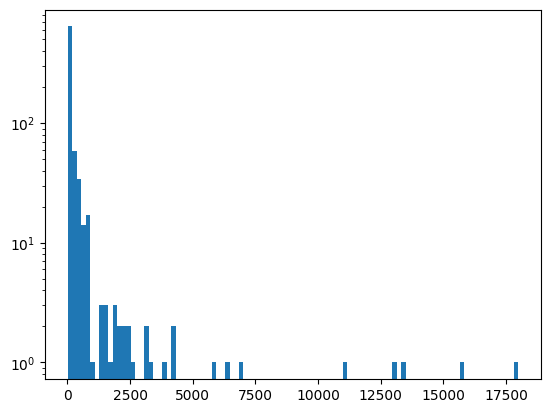

In [132]:
# Original dataset

(
    accuracy_in_sample,
    accuracy_out_of_sample,
    feature_importances,
) = run_decision_tree_model_with_detail_(
    data_copy_train.copy(),
    data_copy_test.copy(),
    decision_tree_columns,
    15,
)

print(f'accuracy in sample: {accuracy_in_sample}')
print(f'accuracy out of sample: {accuracy_out_of_sample}')
print(feature_importances)

len: 1081
index=55, value=[[0.79518072 0.20481928]]
samples=83
index=63, value=[[0.93040293 0.06959707]]
samples=273
index=73, value=[[0.84482759 0.15517241]]
samples=58
index=74, value=[[0.9375 0.0625]]
samples=160
index=76, value=[[0.86842105 0.13157895]]
samples=114
index=77, value=[[0.69354839 0.30645161]]
samples=62
index=84, value=[[0.84 0.16]]
samples=25
index=99, value=[[0.95238095 0.04761905]]
samples=63
index=102, value=[[0.92255892 0.07744108]]
samples=297
index=103, value=[[0.83544304 0.16455696]]
samples=79
index=108, value=[[0.9456869 0.0543131]]
samples=313
index=111, value=[[0.97724687 0.02275313]]
samples=879
index=112, value=[[0.94864048 0.05135952]]
samples=331
index=118, value=[[0.88 0.12]]
samples=25
index=119, value=[[0.98773006 0.01226994]]
samples=163
index=121, value=[[0.88405797 0.11594203]]
samples=69
index=125, value=[[0.90465116 0.09534884]]
samples=430
index=126, value=[[0.65625 0.34375]]
samples=32
index=129, value=[[0.92013889 0.07986111]]
samples=288
in

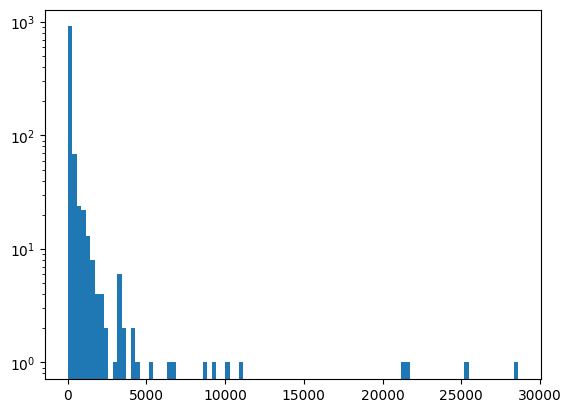

In [145]:
# Original dataset and Kaggle Loan Approval train dataset

(
    accuracy_in_sample,
    accuracy_out_of_sample,
    feature_importances,
) = run_decision_tree_model_with_detail_(
    data_copy.copy(),
    data_train_copy.copy(),
    decision_tree_columns,
    15,
)

print(f'accuracy in sample: {accuracy_in_sample}')
print(f'accuracy out of sample: {accuracy_out_of_sample}')
print(feature_importances)

In [146]:
# Repeat of above, but use full length dataset for training

# Original dataset for training, Kaggle competition test dataset for submission creation

X = data_copy[decision_tree_columns].copy()
Y = data_copy['loan_status'].copy()

X_test = data_test_copy[decision_tree_columns_with_id].copy()

clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=15, 
    min_samples_split=10,
    min_samples_leaf=4,
)
clf = clf.fit(X, Y)

Z = clf.predict(X)
data_copy['loan_status_tree_predict'] = Z
accuracy_in_sample = (data_copy['loan_status'] == data_copy['loan_status_tree_predict']).sum() / len(data_copy)

feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances = feature_importances[feature_importances > 0]

Z_test = clf.predict_proba(X_test[decision_tree_columns])
data_test_copy['loan_status'] = Z_test[:,1]

print(f'accuracy in sample: {accuracy_in_sample}')
print(feature_importances)

data_test_copy[['id', 'loan_status']].to_csv(f'data_test_submission_decision_tree_max_depth_15_proba_full_dataset.csv', index=False)

accuracy in sample: 0.9476459905001398
loan_percent_income               0.230616
loan_grade_numerical              0.217463
person_home_ownership_RENT        0.160174
person_income                     0.138456
person_emp_length                 0.047060
loan_int_rate                     0.035050
person_home_ownership_OWN         0.030824
loan_intent_MEDICAL               0.028552
loan_intent_DEBTCONSOLIDATION     0.024232
person_age                        0.023963
loan_amnt                         0.017027
loan_intent_HOMEIMPROVEMENT       0.013339
loan_intent_VENTURE               0.012387
person_home_ownership_MORTGAGE    0.007984
cb_person_cred_hist_length        0.006397
loan_intent_PERSONAL              0.002180
loan_intent_EDUCATION             0.002146
person_home_ownership_OTHER       0.001210
cb_person_default_on_file         0.000941
dtype: float64
